In [1]:
# Import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error  # Tambahan MAPE
from xgboost import XGBRegressor
import pickle


In [2]:
# Load dataset preprocessed
try:
    with open('/content/drive/MyDrive/project03/Project 3_ House Price Prediction/Dataset/preprocessed_data.pkl', 'rb') as f:
        df = pickle.load(f)
    print("Dataset loaded. Shape:", df.shape)
except FileNotFoundError:
    print("Error: File preprocessed_data.pkl tidak ditemukan. Jalankan preprocessing dulu.")
    exit()

Dataset loaded. Shape: (1460, 109)


In [3]:
# Split data
X = df.drop(['SalePrice', 'SalePrice_log'], axis=1)
y = df['SalePrice_log']


In [4]:
# Check dan clean X
print("n\Dtypes di X:", X.dtypes.value_counts())
object_cols = X.select_dtypes(include=['object']).columns.tolist()
if object_cols:
    X.drop(columns=object_cols, inplace=True)
# print("NaN in X:", X.isnull().sum().sum())
# print("Infinity in X:", np.isinf(X).sum().sum())
# if X.isnull().sum().sum() > 0 or np.isinf(X).sum().sum() > 0:
#     mask = ~X.isnull().any(axis=1) & ~np.isinf(X).any(axis=1)
#     X = X[mask]
#     y = y[mask]

n\Dtypes di X: bool       53
int64      48
float64     6
Name: count, dtype: int64


<>:2: SyntaxWarning: invalid escape sequence '\D'
<>:2: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipython-input-3775159490.py:2: SyntaxWarning: invalid escape sequence '\D'
  print("n\Dtypes di X:", X.dtypes.value_counts())


In [5]:
# PERBAIKAN: Check NaN/infinity di X
print("NaN in X:", X.isnull().sum().sum())
print("Infinity in X:", np.isinf(X).sum().sum())
if X.isnull().sum().sum() > 0 or np.isinf(X).sum().sum() > 0:
    print("Dropping rows with NaN/infinity...")
    mask = ~X.isnull().any(axis=1) & ~np.isinf(X).any(axis=1)
    X = X[mask]
    y = y[mask]

NaN in X: 0
Infinity in X: 0


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")


Train shape: (1168, 107), Test shape: (292, 107)


In [7]:
# Dictionary untuk menyimpan hasil evaluasi
results = {}

In [8]:
# === 1. Linear Regression (Baseline) ===
print("\n=== 1. Linear Regression (Baseline) ===")
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
y_pred_train_lr = model_lr.predict(X_train)
y_pred_test_lr = model_lr.predict(X_test)

results['Linear Regression'] = {
    'R2 Train': r2_score(y_train, y_pred_train_lr),
    'R2 Test': r2_score(y_test, y_pred_test_lr),
    'RMSE Train': np.sqrt(mean_squared_error(y_train, y_pred_train_lr)),
    'RMSE Test': np.sqrt(mean_squared_error(y_test, y_pred_test_lr)),
    'MSE Train': mean_squared_error(y_train, y_pred_train_lr),
    'MSE Test': mean_squared_error(y_test, y_pred_test_lr),
    'MAPE Train (%)': mean_absolute_percentage_error(y_train, y_pred_train_lr) * 100,  # Tambahan MAPE
    'MAPE Test (%)': mean_absolute_percentage_error(y_test, y_pred_test_lr) * 100
}

print("Evaluasi Train:")
print(f"MSE: {results['Linear Regression']['MSE Train']:.4f}, RMSE: {results['Linear Regression']['RMSE Train']:.4f}, R2: {results['Linear Regression']['R2 Train']:.4f}, MAPE: {results['Linear Regression']['MAPE Train (%)']:.2f}%")
print("Evaluasi Test:")
print(f"MSE: {results['Linear Regression']['MSE Test']:.4f}, RMSE: {results['Linear Regression']['RMSE Test']:.4f}, R2: {results['Linear Regression']['R2 Test']:.4f}, MAPE: {results['Linear Regression']['MAPE Test (%)']:.2f}%")



=== 1. Linear Regression (Baseline) ===
Evaluasi Train:
MSE: 0.0176, RMSE: 0.1327, R2: 0.8845, MAPE: 0.79%
Evaluasi Test:
MSE: 0.0220, RMSE: 0.1483, R2: 0.8821, MAPE: 0.89%


In [9]:
# Prediksi contoh untuk LR
X_example = X_test.head(5)  # Ambil 5 baris contoh dari test set
y_actual_example = y_test.head(5)
y_pred_example_lr = model_lr.predict(X_example)
pred_df_lr = pd.DataFrame({
    'Actual SalePrice': np.expm1(y_actual_example),  # Konversi log ke asli
    'Predicted SalePrice': np.expm1(y_pred_example_lr)
})
print("\nPrediksi Contoh (Linear Regression):")
print(pred_df_lr)


Prediksi Contoh (Linear Regression):
      Actual SalePrice  Predicted SalePrice
892           154500.0        137715.577485
1105          325000.0        315840.701567
413           115000.0        109498.948115
522           159000.0        168988.864365
1036          315500.0        316444.197832


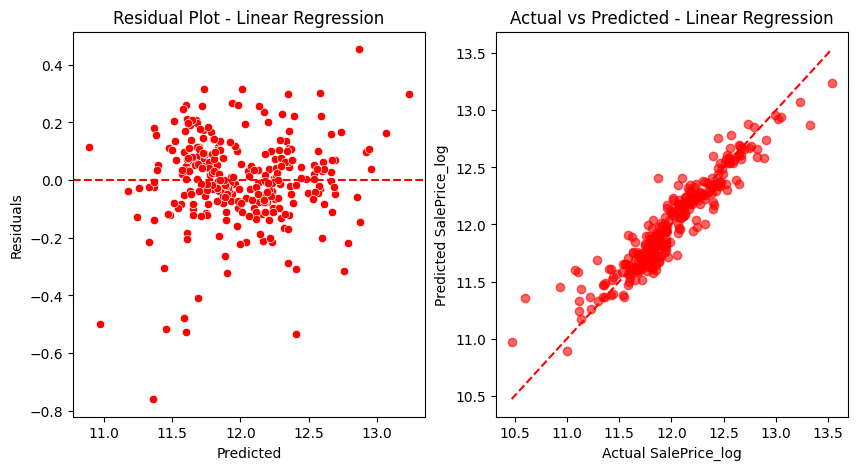

In [10]:
# Visualisasi untuk LR
residuals_lr = y_test - y_pred_test_lr
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_pred_test_lr, y=residuals_lr, color='red')
plt.axhline(0, color='red', linestyle='--')
plt.title('Residual Plot - Linear Regression')
plt.xlabel('Predicted')
plt.ylabel('Residuals')

plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_test_lr, color='red', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title('Actual vs Predicted - Linear Regression')
plt.xlabel('Actual SalePrice_log')
plt.ylabel('Predicted SalePrice_log')
plt.show()


In [11]:
# === 2. Random Forest (Tanpa Tuning) ===
print("\n=== 2. Random Forest (Tanpa Tuning) ===")
model_rf = RandomForestRegressor(random_state=42)
model_rf.fit(X_train, y_train)
y_pred_train_rf = model_rf.predict(X_train)
y_pred_test_rf = model_rf.predict(X_test)
results['Random Forest (No Tuning)'] = {
    'R2 Train': r2_score(y_train, y_pred_train_rf),
    'R2 Test': r2_score(y_test, y_pred_test_rf),
    'RMSE Train': np.sqrt(mean_squared_error(y_train, y_pred_train_rf)),
    'RMSE Test': np.sqrt(mean_squared_error(y_test, y_pred_test_rf)),
    'MSE Train': mean_squared_error(y_train, y_pred_train_rf),
    'MSE Test': mean_squared_error(y_test, y_pred_test_rf),
    'MAPE Train (%)': mean_absolute_percentage_error(y_train, y_pred_train_rf) * 100,  # Tambahan MAPE
    'MAPE Test (%)': mean_absolute_percentage_error(y_test, y_pred_test_rf) * 100
}

print("Evaluasi Train:")
print(f"MSE: {results['Random Forest (No Tuning)']['MSE Train']:.4f}, RMSE: {results['Random Forest (No Tuning)']['RMSE Train']:.4f}, R2: {results['Random Forest (No Tuning)']['R2 Train']:.4f}, MAPE: {results['Random Forest (No Tuning)']['MAPE Train (%)']:.2f}%")
print("Evaluasi Test:")
print(f"MSE: {results['Random Forest (No Tuning)']['MSE Test']:.4f}, RMSE: {results['Random Forest (No Tuning)']['RMSE Test']:.4f}, R2: {results['Random Forest (No Tuning)']['R2 Test']:.4f}, MAPE: {results['Random Forest (No Tuning)']['MAPE Test (%)']:.2f}%")



=== 2. Random Forest (Tanpa Tuning) ===
Evaluasi Train:
MSE: 0.0034, RMSE: 0.0583, R2: 0.9777, MAPE: 0.34%
Evaluasi Test:
MSE: 0.0246, RMSE: 0.1568, R2: 0.8683, MAPE: 0.90%


In [12]:
# Prediksi contoh untuk RF
y_pred_example_rf = model_rf.predict(X_example)
pred_df_rf = pd.DataFrame({
    'Actual SalePrice': np.expm1(y_actual_example),
    'Predicted SalePrice': np.expm1(y_pred_example_rf)
})
print("\nPrediksi Contoh (Random Forest No Tuning):")
print(pred_df_rf)


Prediksi Contoh (Random Forest No Tuning):
      Actual SalePrice  Predicted SalePrice
892           154500.0        136355.031280
1105          325000.0        298244.727771
413           115000.0        122527.388716
522           159000.0        135033.172279
1036          315500.0        351887.853980


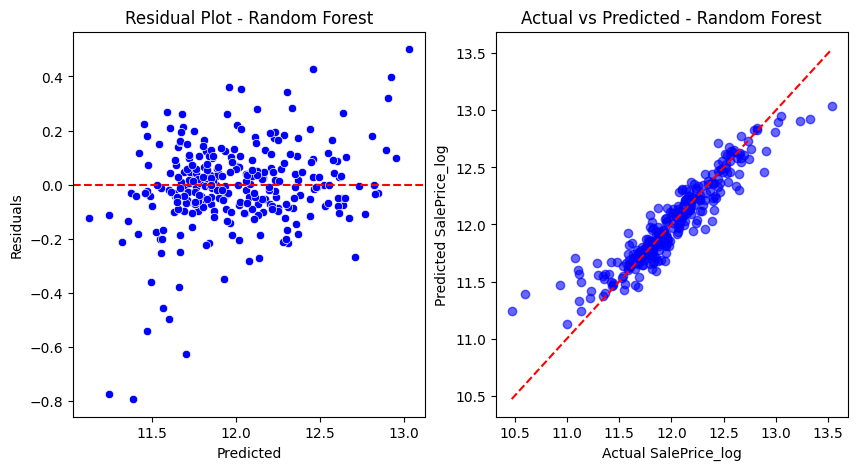

In [13]:
# Visualisasi untuk RF
residuals_rf = y_test - y_pred_test_rf
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_pred_test_rf, y=residuals_rf, color='blue')
plt.axhline(0, color='red', linestyle='--')
plt.title('Residual Plot - Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Residuals')

plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_test_rf, color='blue', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title('Actual vs Predicted - Random Forest')
plt.xlabel('Actual SalePrice_log')
plt.ylabel('Predicted SalePrice_log')
plt.show()

In [14]:
# === 3. XGBoost (Tanpa Tuning) ===
print("\n=== 3. XGBoost (Tanpa Tuning) ===")
model_xgb = XGBRegressor(random_state=42, objective='reg:squarederror')
model_xgb.fit(X_train, y_train)
y_pred_train_xgb = model_xgb.predict(X_train)
y_pred_test_xgb = model_xgb.predict(X_test)
results['XGBoost (No Tuning)'] = {
    'R2 Train': r2_score(y_train, y_pred_train_xgb),
    'R2 Test': r2_score(y_test, y_pred_test_xgb),
    'RMSE Train': np.sqrt(mean_squared_error(y_train, y_pred_train_xgb)),
    'RMSE Test': np.sqrt(mean_squared_error(y_test, y_pred_test_xgb)),
    'MSE Train': mean_squared_error(y_train, y_pred_train_xgb),
    'MSE Test': mean_squared_error(y_test, y_pred_test_xgb),
    'MAPE Train (%)': mean_absolute_percentage_error(y_train, y_pred_train_xgb) * 100,  # Tambahan MAPE
    'MAPE Test (%)': mean_absolute_percentage_error(y_test, y_pred_test_xgb) * 100
}
print("Evaluasi Train:")
print(f"MSE: {results['XGBoost (No Tuning)']['MSE Train']:.4f}, RMSE: {results['XGBoost (No Tuning)']['RMSE Train']:.4f}, R2: {results['XGBoost (No Tuning)']['R2 Train']:.4f}, MAPE: {results['XGBoost (No Tuning)']['MAPE Train (%)']:.2f}%")
print("Evaluasi Test:")
print(f"MSE: {results['XGBoost (No Tuning)']['MSE Test']:.4f}, RMSE: {results['XGBoost (No Tuning)']['RMSE Test']:.4f}, R2: {results['XGBoost (No Tuning)']['R2 Test']:.4f}, MAPE: {results['XGBoost (No Tuning)']['MAPE Test (%)']:.2f}%")



=== 3. XGBoost (Tanpa Tuning) ===
Evaluasi Train:
MSE: 0.0001, RMSE: 0.0083, R2: 0.9995, MAPE: 0.05%
Evaluasi Test:
MSE: 0.0227, RMSE: 0.1507, R2: 0.8783, MAPE: 0.87%


In [15]:
# Prediksi contoh untuk XGBoost No Tuning
y_pred_example_xgb = model_xgb.predict(X_example)
pred_df_xgb = pd.DataFrame({
    'Actual SalePrice': np.expm1(y_actual_example),
    'Predicted SalePrice': np.expm1(y_pred_example_xgb)
})
print("\nPrediksi Contoh (XGBoost No Tuning):")
print(pred_df_xgb)


Prediksi Contoh (XGBoost No Tuning):
      Actual SalePrice  Predicted SalePrice
892           154500.0        135906.500000
1105          325000.0        334925.500000
413           115000.0        109727.914062
522           159000.0        138767.703125
1036          315500.0        375581.031250


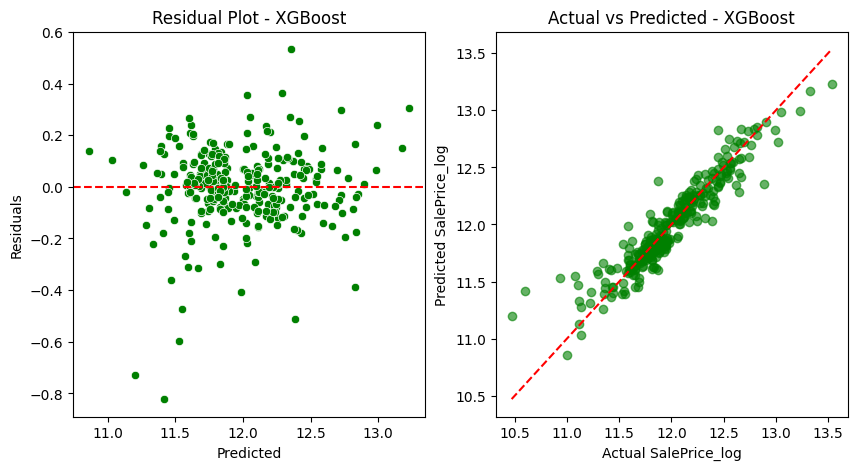

In [16]:
# Visualisasi untuk XGBoost
residuals_xgb = y_test - y_pred_test_xgb
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_pred_test_xgb, y=residuals_xgb, color='green')
plt.axhline(0, color='red', linestyle='--')
plt.title('Residual Plot - XGBoost')
plt.xlabel('Predicted')
plt.ylabel('Residuals')

plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_test_xgb, color='green', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title('Actual vs Predicted - XGBoost')
plt.xlabel('Actual SalePrice_log')
plt.ylabel('Predicted SalePrice_log')
plt.show()


In [17]:
# === 4. Random Forest (Dengan Hyperparameter Tuning - 2 Opsi) ===
print("\n=== 4. Random Forest (Tuning Opsi 1: RandomizedSearchCV) ===")
rf = RandomForestRegressor(random_state=42)
param_dist_rf = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}
rf_search1 = RandomizedSearchCV(rf, param_distributions=param_dist_rf,
                                n_iter=50, cv=3, scoring='neg_mean_squared_error',
                                random_state=42, n_jobs=-1)
rf_search1.fit(X_train, y_train)
best_rf1 = rf_search1.best_estimator_
y_pred_train_rf1 = best_rf1.predict(X_train)
y_pred_test_rf1 = best_rf1.predict(X_test)

results['Random Forest (Tuning Randomized)'] = {
    'R2 Train': r2_score(y_train, y_pred_train_rf1),
    'R2 Test': r2_score(y_test, y_pred_test_rf1),
    'RMSE Train': np.sqrt(mean_squared_error(y_train, y_pred_train_rf1)),
    'RMSE Test': np.sqrt(mean_squared_error(y_test, y_pred_test_rf1)),
    'MSE Train': mean_squared_error(y_train, y_pred_train_rf1),
    'MSE Test': mean_squared_error(y_test, y_pred_test_rf1),
    'MAPE Train (%)': mean_absolute_percentage_error(y_train, y_pred_train_rf1) * 100,  # Tambahan MAPE
    'MAPE Test (%)': mean_absolute_percentage_error(y_test, y_pred_test_rf1) * 100
}
print("Best params:", rf_search1.best_params_)
print("Evaluasi Train:")
print(f"MSE: {results['Random Forest (Tuning Randomized)']['MSE Train']:.4f}, RMSE: {results['Random Forest (Tuning Randomized)']['RMSE Train']:.4f}, R2: {results['Random Forest (Tuning Randomized)']['R2 Train']:.4f}, MAPE: {results['Random Forest (Tuning Randomized)']['MAPE Train (%)']:.2f}%")
print("Evaluasi Test:")
print(f"MSE: {results['Random Forest (Tuning Randomized)']['MSE Test']:.4f}, RMSE: {results['Random Forest (Tuning Randomized)']['RMSE Test']:.4f}, R2: {results['Random Forest (Tuning Randomized)']['R2 Test']:.4f}, MAPE: {results['Random Forest (Tuning Randomized)']['MAPE Test (%)']:.2f}%")



=== 4. Random Forest (Tuning Opsi 1: RandomizedSearchCV) ===
Best params: {'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 30, 'bootstrap': True}
Evaluasi Train:
MSE: 0.0048, RMSE: 0.0692, R2: 0.9686, MAPE: 0.38%
Evaluasi Test:
MSE: 0.0237, RMSE: 0.1540, R2: 0.8728, MAPE: 0.89%


In [53]:
print("\n=== 4. Random Forest (Tuning Opsi 1: RandomizedSearchCV) ===")
print("Best params:")
print(rf_search1.best_params_)
print("Evaluasi Train:")
print(f"MSE: {results['Random Forest (Tuning Randomized)']['MSE Train']:.4f}, RMSE: {results['Random Forest (Tuning Randomized)']['RMSE Train']:.4f}, R2: {results['Random Forest (Tuning Randomized)']['R2 Train']:.4f}, MAPE: {results['Random Forest (Tuning Randomized)']['MAPE Train (%)']:.2f}%")
print("Evaluasi Test:")
print(f"MSE: {results['Random Forest (Tuning Randomized)']['MSE Test']:.4f}, RMSE: {results['Random Forest (Tuning Randomized)']['RMSE Test']:.4f}, R2: {results['Random Forest (Tuning Randomized)']['R2 Test']:.4f}, MAPE: {results['Random Forest (Tuning Randomized)']['MAPE Test (%)']:.2f}%")



=== 4. Random Forest (Tuning Opsi 1: RandomizedSearchCV) ===
Best params:
{'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 30, 'bootstrap': True}
Evaluasi Train:
MSE: 0.0048, RMSE: 0.0692, R2: 0.9686, MAPE: 0.38%
Evaluasi Test:
MSE: 0.0237, RMSE: 0.1540, R2: 0.8728, MAPE: 0.89%


In [18]:
# Prediksi contoh untuk RF Tuning Randomized
y_pred_example_rf1 = best_rf1.predict(X_example)
pred_df_rf1 = pd.DataFrame({
    'Actual SalePrice': np.expm1(y_actual_example),
    'Predicted SalePrice': np.expm1(y_pred_example_rf1)
})
print("\nPrediksi Contoh (Random Forest Tuning Randomized):")
print(pred_df_rf1)


Prediksi Contoh (Random Forest Tuning Randomized):
      Actual SalePrice  Predicted SalePrice
892           154500.0        138734.168500
1105          325000.0        303033.052929
413           115000.0        122276.818133
522           159000.0        137038.314882
1036          315500.0        352923.658392


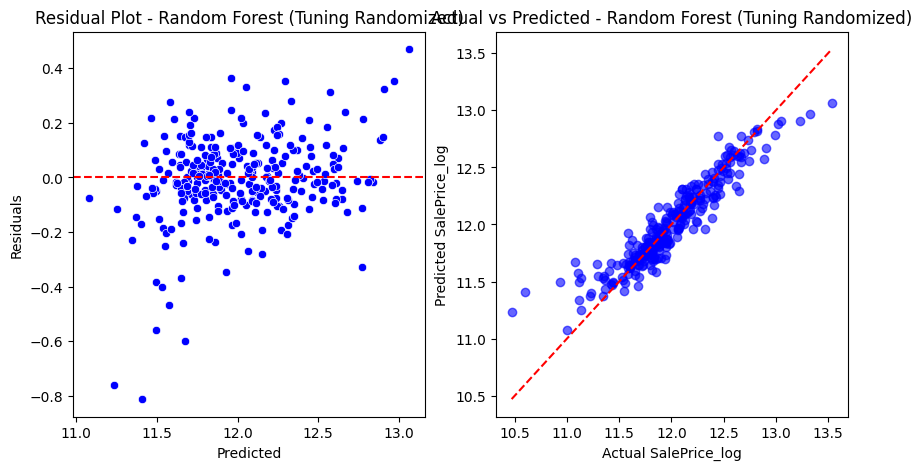

In [19]:
# Visualisasi untuk Random Forest (Tuning Randomized)
residuals_rf1 = y_test - y_pred_test_rf1
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_pred_test_rf1, y=residuals_rf1, color='blue')
plt.axhline(0, color='red', linestyle='--')
plt.title('Residual Plot - Random Forest (Tuning Randomized)')
plt.xlabel('Predicted')
plt.ylabel('Residuals')

plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_test_rf1, color='blue', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title('Actual vs Predicted - Random Forest (Tuning Randomized)')
plt.xlabel('Actual SalePrice_log')
plt.ylabel('Predicted SalePrice_log')
plt.show()

In [61]:
print("\n=== 4. Random Forest (Tuning Opsi 2: GridSearchCV) ===")
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5]
}
rf_search2 = GridSearchCV(rf, param_grid=param_grid_rf,
                          cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
rf_search2.fit(X_train, y_train)
best_rf2 = rf_search2.best_estimator_
y_pred_train_rf2 = best_rf2.predict(X_train)
y_pred_test_rf2 = best_rf2.predict(X_test)

results['Random Forest (Tuning Grid)'] = {
    'R2 Train': r2_score(y_train, y_pred_train_rf2),
    'R2 Test': r2_score(y_test, y_pred_test_rf2),
    'RMSE Train': np.sqrt(mean_squared_error(y_train, y_pred_train_rf2)),
    'RMSE Test': np.sqrt(mean_squared_error(y_test, y_pred_test_rf2)),
    'MSE Train': mean_squared_error(y_train, y_pred_train_rf2),
    'MSE Test': mean_squared_error(y_test, y_pred_test_rf2),
    'MAPE Train (%)': mean_absolute_percentage_error(y_train, y_pred_train_rf2) * 100,  # Tambahan MAPE
    'MAPE Test (%)': mean_absolute_percentage_error(y_test, y_pred_test_rf2) * 100
}
print("Best params:", rf_search2.best_params_)
print("Evaluasi Train:")
print(f"MSE: {results['Random Forest (Tuning Grid)']['MSE Train']:.4f}, RMSE: {results['Random Forest (Tuning Grid)']['RMSE Train']:.4f}, R2: {results['Random Forest (Tuning Grid)']['R2 Train']:.4f}, MAPE: {results['Random Forest (Tuning Grid)']['MAPE Train (%)']:.2f}%")
print("Evaluasi Test:")
print(f"MSE: {results['Random Forest (Tuning Grid)']['MSE Test']:.4f}, RMSE: {results['Random Forest (Tuning Grid)']['RMSE Test']:.4f}, R2: {results['Random Forest (Tuning Grid)']['R2 Test']:.4f}, MAPE: {results['Random Forest (Tuning Grid)']['MAPE Test (%)']:.2f}%")



=== 4. Random Forest (Tuning Opsi 2: GridSearchCV) ===
Best params: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
Evaluasi Train:
MSE: 0.0033, RMSE: 0.0571, R2: 0.9786, MAPE: 0.33%
Evaluasi Test:
MSE: 0.0240, RMSE: 0.1549, R2: 0.8715, MAPE: 0.89%


In [21]:
# Prediksi contoh untuk RF Tuning Grid
y_pred_example_rf2 = best_rf2.predict(X_example)
pred_df_rf2 = pd.DataFrame({
    'Actual SalePrice': np.expm1(y_actual_example),
    'Predicted SalePrice': np.expm1(y_pred_example_rf2)
})
print("\nPrediksi Contoh (Random Forest Tuning Grid):")
print(pred_df_rf2)


Prediksi Contoh (Random Forest Tuning Grid):
      Actual SalePrice  Predicted SalePrice
892           154500.0        137941.116549
1105          325000.0        304836.988166
413           115000.0        120587.306845
522           159000.0        135771.002220
1036          315500.0        348931.451009


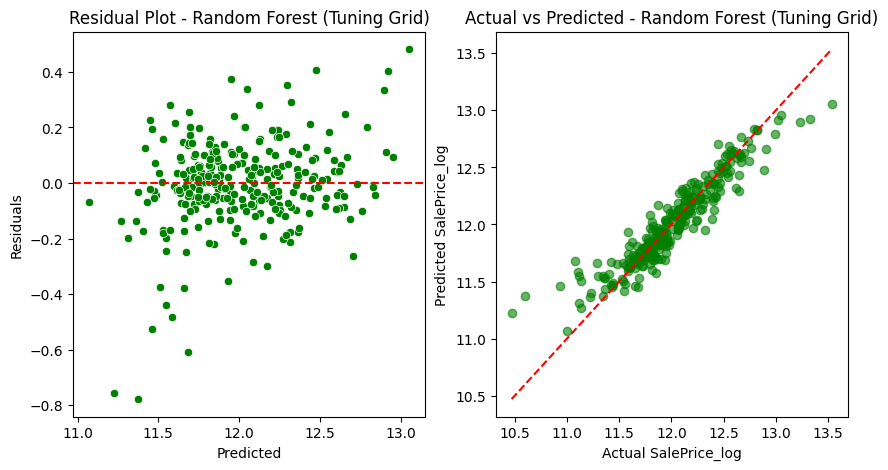

In [22]:
# Visualisasi untuk Random Forest (Tuning Grid)
residuals_rf2 = y_test - y_pred_test_rf2
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_pred_test_rf2, y=residuals_rf2, color='green')
plt.axhline(0, color='red', linestyle='--')
plt.title('Residual Plot - Random Forest (Tuning Grid)')
plt.xlabel('Predicted')
plt.ylabel('Residuals')

plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_test_rf2, color='green', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title('Actual vs Predicted - Random Forest (Tuning Grid)')
plt.xlabel('Actual SalePrice_log')
plt.ylabel('Predicted SalePrice_log')
plt.show()

In [56]:
# === 5. XGBoost (Dengan Hyperparameter Tuning - 2 Opsi) ===
print("\n=== 5. XGBoost (Tuning Opsi 1: RandomizedSearchCV) ===")
xgb = XGBRegressor(random_state=42, objective='reg:squarederror')
param_dist_xgb = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}
xgb_search1 = RandomizedSearchCV(xgb, param_distributions=param_dist_xgb,
                                 n_iter=50, cv=3, scoring='neg_mean_squared_error',
                                 random_state=42, n_jobs=-1)
xgb_search1.fit(X_train, y_train)
best_xgb1 = xgb_search1.best_estimator_
y_pred_train_xgb1 = best_xgb1.predict(X_train)
y_pred_test_xgb1 = best_xgb1.predict(X_test)

results['XGBoost (Tuning Randomized)'] = {
    'R2 Train': r2_score(y_train, y_pred_train_xgb1),
    'R2 Test': r2_score(y_test, y_pred_test_xgb1),
    'RMSE Train': np.sqrt(mean_squared_error(y_train, y_pred_train_xgb1)),
    'RMSE Test': np.sqrt(mean_squared_error(y_test, y_pred_test_xgb1)),
    'MSE Train': mean_squared_error(y_train, y_pred_train_xgb1),
    'MSE Test': mean_squared_error(y_test, y_pred_test_xgb1),
    'MAPE Train (%)': mean_absolute_percentage_error(y_train, y_pred_train_xgb1) * 100,  # Tambahan MAPE
    'MAPE Test (%)': mean_absolute_percentage_error(y_test, y_pred_test_xgb1) * 100

}
print("Best params:", xgb_search1.best_params_)
print("Evaluasi Train:")
print(f"MSE: {results['XGBoost (Tuning Randomized)']['MSE Train']:.4f}, RMSE: {results['XGBoost (Tuning Randomized)']['RMSE Train']:.4f}, R2: {results['XGBoost (Tuning Randomized)']['R2 Train']:.4f}, MAPE: {results['XGBoost (Tuning Randomized)']['MAPE Train (%)']:.2f}%")
print("Evaluasi Test:")
print(f"MSE: {results['XGBoost (Tuning Randomized)']['MSE Test']:.4f}, RMSE: {results['XGBoost (Tuning Randomized)']['RMSE Test']:.4f}, R2: {results['XGBoost (Tuning Randomized)']['R2 Test']:.4f}, MAPE: {results['XGBoost (Tuning Randomized)']['MAPE Test (%)']:.2f}%")



=== 5. XGBoost (Tuning Opsi 1: RandomizedSearchCV) ===
Best params: {'subsample': 0.9, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 0.9}
Evaluasi Train:
MSE: 0.0066, RMSE: 0.0811, R2: 0.9569, MAPE: 0.50%
Evaluasi Test:
MSE: 0.0196, RMSE: 0.1399, R2: 0.8951, MAPE: 0.79%


In [59]:
print("\n=== 5. XGBoost (Tuning Opsi 1: RandomizedSearchCV) ===")
print("Best params:")
print(xgb_search1.best_params_)
print("Evaluasi Train:")
print(f"MSE: {results['XGBoost (Tuning Randomized)']['MSE Train']:.4f}, RMSE: {results['XGBoost (Tuning Randomized)']['RMSE Train']:.4f}, R2: {results['XGBoost (Tuning Randomized)']['R2 Train']:.4f}, MAPE: {results['XGBoost (Tuning Randomized)']['MAPE Train (%)']:.2f}%")
print("Evaluasi Test:")
print(f"MSE: {results['XGBoost (Tuning Randomized)']['MSE Test']:.4f}, RMSE: {results['XGBoost (Tuning Randomized)']['RMSE Test']:.4f}, R2: {results['XGBoost (Tuning Randomized)']['R2 Test']:.4f}, MAPE: {results['XGBoost (Tuning Randomized)']['MAPE Test (%)']:.2f}%")



=== 5. XGBoost (Tuning Opsi 1: RandomizedSearchCV) ===
Best params:
{'subsample': 0.9, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 0.9}
Evaluasi Train:
MSE: 0.0066, RMSE: 0.0811, R2: 0.9569, MAPE: 0.50%
Evaluasi Test:
MSE: 0.0196, RMSE: 0.1399, R2: 0.8951, MAPE: 0.79%


In [24]:
# Prediksi untuk beberapa contoh (5 sampel pertama dari test set)
num_examples = 5  # Ubah angka ini untuk lebih banyak contoh
predictions = []
for i in range(num_examples):
    example_X = X_test.iloc[i:i+1]
    actual_y_log = y_test.iloc[i]
    actual_y_original = np.expm1(actual_y_log)  # Inverse log untuk actual SalePrice asli
    predicted_y_log = best_xgb1.predict(example_X)[0]
    predicted_y_original = np.expm1(predicted_y_log)
    gap = predicted_y_original - actual_y_original  # Gap antara predicted dan actual
    predictions.append({
        'Sample': i+1,
        'Actual SalePrice_log': actual_y_log,
        'Actual SalePrice (original)': actual_y_original,
        'Predicted SalePrice_log': predicted_y_log,
        'Predicted SalePrice (original)': predicted_y_original,
        'Gap (Predicted - Actual)': gap
    })
# Tampilkan hasil prediksi dalam tabel
predictions_df = pd.DataFrame(predictions)
print(f"\nContoh Prediksi untuk XGBoost (Tuning Randomized) - {num_examples} Sampel:")
print(predictions_df)



Contoh Prediksi untuk XGBoost (Tuning Randomized) - 5 Sampel:
   Sample  Actual SalePrice_log  Actual SalePrice (original)  \
0       1             11.947956                     154500.0   
1       2             12.691584                     325000.0   
2       3             11.652696                     115000.0   
3       4             11.976666                     159000.0   
4       5             12.661917                     315500.0   

   Predicted SalePrice_log  Predicted SalePrice (original)  \
0                11.841960                   138961.578125   
1                12.709783                   330968.875000   
2                11.566351                   105486.835938   
3                11.806346                   134099.656250   
4                12.750811                   344830.312500   

   Gap (Predicted - Actual)  
0             -15538.421875  
1               5968.875000  
2              -9513.164062  
3             -24900.343750  
4              29330.312500  

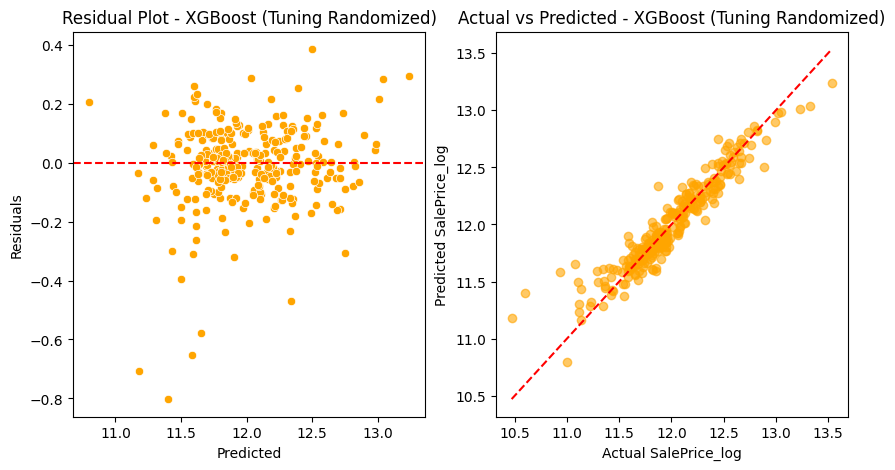

In [60]:
# Visualisasi untuk XGBoost (Tuning Grid)
residuals_xgb1 = y_test - y_pred_test_xgb1
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_pred_test_xgb1, y=residuals_xgb1, color='orange')
plt.axhline(0, color='red', linestyle='--')
plt.title('Residual Plot - XGBoost (Tuning Randomized)')
plt.xlabel('Predicted')
plt.ylabel('Residuals')

plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_test_xgb1, color='orange', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title('Actual vs Predicted - XGBoost (Tuning Randomized)')
plt.xlabel('Actual SalePrice_log')
plt.ylabel('Predicted SalePrice_log')
plt.show()

In [54]:
print("\n=== 5. XGBoost (Tuning Opsi 2: GridSearchCV) ===")
param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.1, 0.2]
}
xgb_search2 = GridSearchCV(xgb, param_grid=param_grid_xgb, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
xgb_search2.fit(X_train, y_train)
best_xgb2 = xgb_search2.best_estimator_
y_pred_train_xgb2 = best_xgb2.predict(X_train)
y_pred_test_xgb2 = best_xgb2.predict(X_test)

results['XGBoost (Tuning Grid)'] = {
    'R2 Train': r2_score(y_train, y_pred_train_xgb2),
    'R2 Test': r2_score(y_test, y_pred_test_xgb2),
    'RMSE Train': np.sqrt(mean_squared_error(y_train, y_pred_train_xgb2)),
    'RMSE Test': np.sqrt(mean_squared_error(y_test, y_pred_test_xgb2)),
    'MSE Train': mean_squared_error(y_train, y_pred_train_xgb2),
    'MSE Test': mean_squared_error(y_test, y_pred_test_xgb2),
    'MAPE Train (%)': mean_absolute_percentage_error(y_train, y_pred_train_xgb2) * 100,  # Tambahan MAPE
    'MAPE Test (%)': mean_absolute_percentage_error(y_test, y_pred_test_xgb2) * 100

}
print("Best params:", xgb_search2.best_params_)
print("Evaluasi Train:")
print(f"MSE: {results['XGBoost (Tuning Grid)']['MSE Train']:.4f}, RMSE: {results['XGBoost (Tuning Grid)']['RMSE Train']:.4f}, R2: {results['XGBoost (Tuning Grid)']['R2 Train']:.4f}, MAPE: {results['XGBoost (Tuning Grid)']['MAPE Train (%)']:.2f}%")
print("Evaluasi Test:")
print(f"MSE: {results['XGBoost (Tuning Grid)']['MSE Test']:.4f}, RMSE: {results['XGBoost (Tuning Grid)']['RMSE Test']:.4f}, R2: {results['XGBoost (Tuning Grid)']['R2 Test']:.4f}, , MAPE: {results['XGBoost (Tuning Grid)']['MAPE Test (%)']:.2f}%")



=== 5. XGBoost (Tuning Opsi 2: GridSearchCV) ===
Best params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
Evaluasi Train:
MSE: 0.0056, RMSE: 0.0745, R2: 0.9636, MAPE: 0.46%
Evaluasi Test:
MSE: 0.0195, RMSE: 0.1397, R2: 0.8953, , MAPE: 0.79%


In [27]:
# Prediksi untuk beberapa contoh (5 sampel pertama dari test set)
num_examples = 5  # Ubah angka ini untuk lebih banyak contoh
predictions = []
for i in range(num_examples):
    example_X = X_test.iloc[i:i+1]
    actual_y_log = y_test.iloc[i]
    actual_y_original = np.expm1(actual_y_log)  # Inverse log untuk actual SalePrice asli
    predicted_y_log = best_xgb2.predict(example_X)[0]
    predicted_y_original = np.expm1(predicted_y_log)
    gap = predicted_y_original - actual_y_original  # Gap antara predicted dan actual
    predictions.append({
        'Sample': i+1,
        'Actual SalePrice_log': actual_y_log,
        'Actual SalePrice (original)': actual_y_original,
        'Predicted SalePrice_log': predicted_y_log,
        'Predicted SalePrice (original)': predicted_y_original,
        'Gap (Predicted - Actual)': gap
    })
# Tampilkan hasil prediksi dalam tabel
predictions_df = pd.DataFrame(predictions)
print(f"\nContoh Prediksi untuk XGBoost (Tuning Grid) - {num_examples} Sampel:")
print(predictions_df)


Contoh Prediksi untuk XGBoost (Tuning Grid) - 5 Sampel:
   Sample  Actual SalePrice_log  Actual SalePrice (original)  \
0       1             11.947956                     154500.0   
1       2             12.691584                     325000.0   
2       3             11.652696                     115000.0   
3       4             11.976666                     159000.0   
4       5             12.661917                     315500.0   

   Predicted SalePrice_log  Predicted SalePrice (original)  \
0                11.838540                   138487.156250   
1                12.708264                   330466.750000   
2                11.619888                   111288.289062   
3                11.808533                   134393.218750   
4                12.775211                   353347.937500   

   Gap (Predicted - Actual)  
0             -16012.843750  
1               5466.750000  
2              -3711.710937  
3             -24606.781250  
4              37847.937500  


In [28]:
# Prediksi contoh untuk XGBoost (Tuning Grid)
predicted_y_xgb2 = best_xgb2.predict(X_example)
print(f"\nContoh Prediksi untuk XGBoost (Tuning Grid):")
print(f"Actual SalePrice_log: {y_actual_example.iloc[0]:.4f}")
print(f"Predicted SalePrice_log: {predicted_y_xgb2[0]:.4f}")
print(f"Predicted SalePrice (original): {np.expm1(predicted_y_xgb2[0]):.2f}")


Contoh Prediksi untuk XGBoost (Tuning Grid):
Actual SalePrice_log: 11.9480
Predicted SalePrice_log: 11.8385
Predicted SalePrice (original): 138487.16



=== Classification Report untuk XGBoost (Tuning Grid) ===
              precision    recall  f1-score   support

        High       0.88      0.95      0.91        95
         Low       0.85      0.92      0.88       109
      Medium       0.81      0.66      0.72        88

    accuracy                           0.85       292
   macro avg       0.85      0.84      0.84       292
weighted avg       0.85      0.85      0.84       292



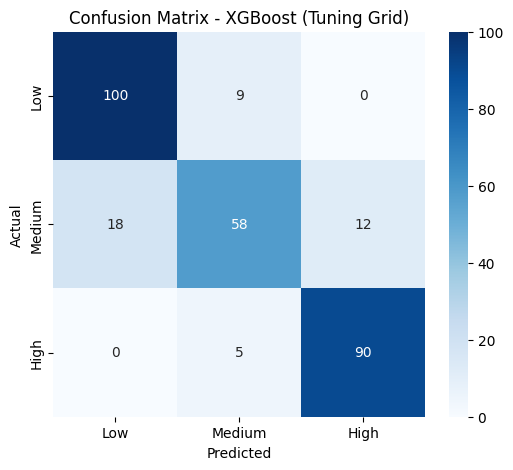

In [29]:
# Import tambahan untuk classification report
from sklearn.metrics import classification_report
# Kategorikan SalePrice menjadi 3 kelas untuk simulasi klasifikasi
def categorize_price(price):
    if price < np.percentile(df['SalePrice'], 33):
        return 'Low'
    elif price < np.percentile(df['SalePrice'], 66):
        return 'Medium'
    else:
        return 'High'
# Kategorikan y_test dan y_pred
y_test_cat = y_test.apply(lambda x: categorize_price(np.expm1(x)))
y_pred_cat = pd.Series(y_pred_test_xgb2).apply(lambda x: categorize_price(np.expm1(x)))
print("\n=== Classification Report untuk XGBoost (Tuning Grid) ===")
print(classification_report(y_test_cat, y_pred_cat))
# Visualisasi confusion matrix (meskipun bukan regresi, tapi untuk simulasi)
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test_cat, y_pred_cat, labels=['Low', 'Medium', 'High'])
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Low', 'Medium', 'High'], yticklabels=['Low', 'Medium', 'High'])
plt.title('Confusion Matrix - XGBoost (Tuning Grid)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

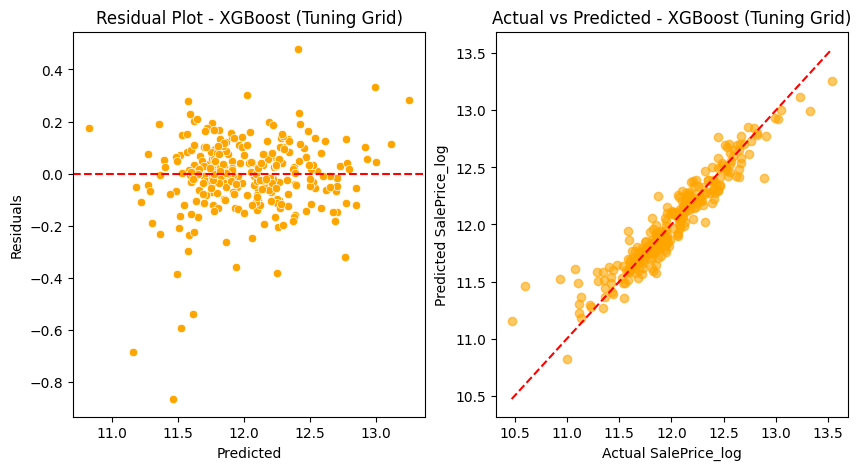

In [30]:
# Visualisasi untuk XGBoost (Tuning Grid)
residuals_xgb2 = y_test - y_pred_test_xgb2
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_pred_test_xgb2, y=residuals_xgb2, color='orange')
plt.axhline(0, color='red', linestyle='--')
plt.title('Residual Plot - XGBoost (Tuning Grid)')
plt.xlabel('Predicted')
plt.ylabel('Residuals')

plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_test_xgb2, color='orange', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title('Actual vs Predicted - XGBoost (Tuning Grid)')
plt.xlabel('Actual SalePrice_log')
plt.ylabel('Predicted SalePrice_log')
plt.show()

In [57]:
# === 1. Perbandingan Antar Model ===
print("\n=== Perbandingan Antar Model ===")
comparison = pd.DataFrame(results).T
print(comparison)


=== Perbandingan Antar Model ===
                                   R2 Train   R2 Test  RMSE Train  RMSE Test  \
Linear Regression                  0.884488  0.882119    0.132699   0.148317   
Random Forest (No Tuning)          0.977723  0.868251    0.058275   0.156798   
XGBoost (No Tuning)                0.999545  0.878297    0.008329   0.150702   
Random Forest (Tuning Randomized)  0.968593  0.872849    0.069194   0.154038   
Random Forest (Tuning Grid)        0.978641  0.871457    0.057062   0.154879   
XGBoost (Tuning Randomized)        0.956893  0.895054    0.081064   0.139943   
XGBoost (Tuning Grid)              0.963586  0.895347    0.074505   0.139748   

                                   MSE Train  MSE Test  MAPE Train (%)  \
Linear Regression                   0.017609  0.021998        0.785911   
Random Forest (No Tuning)           0.003396  0.024586        0.335925   
XGBoost (No Tuning)                 0.000069  0.022711        0.047669   
Random Forest (Tuning Randomi

In [32]:
# === FEATURE IMPORTANCE ANALYSIS ===
# Import library tambahan untuk feature importance
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [33]:

# Pisahkan fitur (X) dan target (y) - gunakan 'SalePrice_log' jika ada, atau 'SalePrice'
target_col = 'SalePrice_log' if 'SalePrice_log' in df.columns else 'SalePrice'
X = df.drop(columns=[target_col, 'SalePrice'] if 'SalePrice' in df.columns and target_col != 'SalePrice' else [target_col])
y = df[target_col]


In [34]:
# === 2. Kesimpulan Model Terbaik/Teroptimal ===
best_model_name = comparison['R2 Test'].idxmax()
best_r2_test = comparison['R2 Test'].max()
best_r2_train = comparison.loc[best_model_name, 'R2 Train']
print(f"\n=== Kesimpulan ===")
print(f"Model terbaik berdasarkan R2 Test tertinggi adalah: {best_model_name} dengan R2 Test = {best_r2_test:.4f}")
print(f"R2 Train untuk model ini: {best_r2_train:.4f}")
if abs(best_r2_train - best_r2_test) < 0.1:
    print("Model ini teroptimal karena R2 Train dan Test seimbang (tidak overfitting/underfitting).")
else:
    print("Model ini mungkin overfitting")



=== Kesimpulan ===
Model terbaik berdasarkan R2 Test tertinggi adalah: XGBoost (Tuning Grid) dengan R2 Test = 0.8953
R2 Train untuk model ini: 0.9636
Model ini teroptimal karena R2 Train dan Test seimbang (tidak overfitting/underfitting).


In [35]:
# # === PERBANDINGAN MODEL ===
# print("\n=== Perbandingan Model ===")
# comparison = pd.DataFrame({
#     'Model': ['Linear Regression', 'Random Forest', 'XGBoost'],
#     'R2 Train': [r2_train_lr, r2_train_rf, r2_train_xgb],
#     'R2 Test': [r2_test_lr, r2_test_rf, r2_test_xgb],
#     'RMSE Train': [rmse_train_lr, rmse_train_rf, rmse_train_xgb],
#     'RMSE Test': [rmse_test_lr, rmse_test_rf, rmse_test_xgb],
#     'MSE Train': [mse_train_lr, mse_train_rf, mse_train_xgb],
#     'MSE Test': [mse_test_lr, mse_test_rf, mse_test_xgb]
# })
# print(comparison)

In [36]:
# print("Evaluasi Train:")
# print(f"MSE: {mse_train_xgb:.4f}, RMSE: {rmse_train_xgb:.4f}, R2: {r2_train_xgb:.4f}")
# print("Evaluasi Test:")
# print(f"MSE: {mse_test_xgb:.4f}, RMSE: {rmse_test_xgb:.4f}, R2: {r2_test_xgb:.4f}")


In [37]:
# # Train Linear Regression
# model = LinearRegression()
# model.fit(X_train, y_train)
# print("Model trained.")


In [38]:
# # Prediksi
# y_pred_train = model.predict(X_train)
# y_pred_test = model.predict(X_test)

In [39]:
# # Evaluasi
# mse_train = mean_squared_error(y_train, y_pred_train)
# rmse_train = np.sqrt(mse_train)
# r2_train = r2_score(y_train, y_pred_train)
# mse_test = mean_squared_error(y_test, y_pred_test)
# rmse_test = np.sqrt(mse_test)
# r2_test = r2_score(y_test, y_pred_test)

In [40]:
# print("\nEvaluasi Train:")
# print(f"MSE: {mse_train:.4f}, RMSE: {rmse_train:.4f}, R2: {r2_train:.4f}")
# print("\nEvaluasi Test:")
# print(f"MSE: {mse_test:.4f}, RMSE: {rmse_test:.4f}, R2: {r2_test:.4f}")


In [41]:
# # Visualisasi Residuals (PERBAIKAN: Ubah color='magma' menjadi color='red')
# residuals = y_test - y_pred_test
# plt.figure(figsize=(10, 5))
# plt.subplot(1, 2, 1)
# sns.scatterplot(x=y_pred_test, y=residuals, color='red')  # Gunakan warna tunggal
# plt.axhline(0, color='red', linestyle='--')
# plt.title('Residual Plot')
# plt.xlabel('Predicted')
# plt.ylabel('Residuals')

In [42]:
# # Visualisasi Actual vs Predicted
# plt.subplot(1, 2, 2)
# plt.scatter(y_test, y_pred_test, color='red', alpha=0.6)  # Gunakan warna tunggal untuk konsistensi
# plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
# plt.title('Actual vs Predicted')
# plt.xlabel('Actual SalePrice_log')
# plt.ylabel('Predicted SalePrice_log')
# plt.show()

In [43]:
# # Simpan model
# path = '/content/drive/MyDrive/project03/Project 3_ House Price Prediction/Dataset/'
# try:
#     with open(path + 'linear_regression_model.pkl', 'wb') as f:
#         pickle.dump(model, f)
#     print(f"Model disimpan ke {path}linear_regression_model.pkl")
# except Exception as e:
#     print(f"Error menyimpan model: {e}")

In [44]:
# # Kode untuk Load Model dan Prediksi (contoh)
# print("\n=== Kode Load Model ===")
# print("import pickle")
# print("with open('/content/drive/MyDrive/project03/Project 3_ House Price Prediction/Dataset/linear_regression_model.pkl', 'rb') as f:")
# print("    model_loaded = pickle.load(f)")
# print("# Prediksi contoh: model_loaded.predict(X_test.iloc[:5])")


In [45]:
# # Hyperparameter Tuning untuk XGBoost
# xgb = XGBRegressor(random_state=42, objective='reg:squarederror')
# param_dist_xgb = {
#     'n_estimators': [100, 200, 300, 400],  # Jumlah boosting rounds
#     'max_depth': [3, 5, 7, 9],  # Kedalaman maksimal
#     'learning_rate': [0.01, 0.05, 0.1, 0.2],  # Tingkat pembelajaran
#     'subsample': [0.8, 0.9, 1.0],  # Fraksi sampel untuk training
#     'colsample_bytree': [0.8, 0.9, 1.0]  # Fraksi fitur per pohon
# }
# xgb_search = RandomizedSearchCV(xgb, param_distributions=param_dist_xgb, n_iter=50, cv=3, scoring='neg_mean_squared_error', random_state=42, n_jobs=-1)
# xgb_search.fit(X_train, y_train)
# print("Best params XGBoost:", xgb_search.best_params_)


In [46]:
# # Train model terbaik
# best_xgb = xgb_search.best_estimator_
# y_pred_train_xgb = best_xgb.predict(X_train)
# y_pred_test_xgb = best_xgb.predict(X_test)

In [47]:
# # Evaluasi
# mse_train_xgb = mean_squared_error(y_train, y_pred_train_xgb)
# rmse_train_xgb = np.sqrt(mse_train_xgb)
# r2_train_xgb = r2_score(y_train, y_pred_train_xgb)
# mse_test_xgb = mean_squared_error(y_test, y_pred_test_xgb)
# rmse_test_xgb = np.sqrt(mse_test_xgb)
# r2_test_xgb = r2_score(y_test, y_pred_test_xgb)

# print("\nEvaluasi XGBoost Train:")
# print(f"MSE: {mse_train_xgb:.4f}, RMSE: {rmse_train_xgb:.4f}, R2: {r2_train_xgb:.4f}")
# print("\nEvaluasi XGBoost Test:")
# print(f"MSE: {mse_test_xgb:.4f}, RMSE: {rmse_test_xgb:.4f}, R2: {r2_test_xgb:.4f}")


In [48]:
# # Visualisasi Residuals
# residuals_xgb = y_test - y_pred_test_xgb
# plt.figure(figsize=(10, 5))
# plt.subplot(1, 2, 1)
# sns.scatterplot(x=y_pred_test_xgb, y=residuals_xgb, color='green')
# plt.axhline(0, color='red', linestyle='--')
# plt.title('Residual Plot - XGBoost')
# plt.xlabel('Predicted')
# plt.ylabel('Residuals')

In [49]:
# # Visualisasi Actual vs Predicted
# plt.subplot(1, 2, 2)
# plt.scatter(y_test, y_pred_test_xgb, color='green', alpha=0.6)
# plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
# plt.title('Actual vs Predicted - XGBoost')
# plt.xlabel('Actual SalePrice_log')
# plt.ylabel('Predicted SalePrice_log')
# plt.show()